# 1d polynya growth model

https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/JC092iC07p07049

In [3]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import calendar
from calendar import monthrange

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize
from matplotlib.ticker import MultipleLocator

import matplotlib.dates as mdates

# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy import img_transform

from metpy.units import units


# path to own functions
sys.path.append('../../')
import timeseries.adjust as tseries
import geofunc.general as geogen
import geofunc.vectors as vectors
import geofunc.shapes as geoshape

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Save to file
df = pd.read_csv('../data/constants.csv')
df = df.set_index('var')
df

cst = {}
for variable in list(df.index):
    cst[variable] = df.loc[variable]['value'] * units(df.loc[variable]['units'])
    
cst

{'Cp_o': <Quantity(3850.0, 'joule / kilogram / delta_degree_Celsius')>,
 'Cp_a': <Quantity(1004.0, 'joule / kilogram / delta_degree_Celsius')>,
 'sigma_sb': <Quantity(5.670367e-08, 'watt / meter ** 2 / kelvin ** 4')>,
 'rho_a': <Quantity(1.225, 'kilogram / meter ** 3')>,
 'rho_o': <Quantity(1028.0, 'kilogram / meter ** 3')>,
 'rho_i': <Quantity(917.0, 'kilogram / meter ** 3')>,
 'L_i': <Quantity(334000.0, 'joule / kilogram')>,
 'k_i': <Quantity(2.2, 'watt / meter / delta_degree_Celsius')>,
 'kappa': <Quantity(0.4, 'dimensionless')>,
 'St': <Quantity(0.0057, 'dimensionless')>,
 'omega': <Quantity(7.2921e-05, 'radian / second')>}

In [5]:
Fi = 1 * units('cm/hour')

type(Fi)

pint.Quantity

In [6]:
def xp_over_time_iter(Vi, t, Fi, Hi = 1 * units('m')):

    Xp = np.array([0]) * units('km')
    
#     Xip = np.append(0*units('km'), np.cumsum((Vi[:-1].to(f'km/{time_unit}'))*np.diff(t)))
    
#     Xip = (np.cumsum(Vi.to('km/hour'))).to('km')
    
    for tt in range(len(t)-1):
        
        Xp_tm1 = Xp[-1].to('km')
        
        dt = (t[tt+1] - t[tt]).to('hour')
        dXp = ((Vi[tt] - Xp_tm1 * Fi[tt] / Hi) * dt).to('km')
        
        Xp_t = dXp + Xp_tm1
        
        Xp = np.append(Xp, Xp_t)
        
    return Xp
        
        
    
    
    
def xp_over_time(Vi, t, Fi, Hi = 1 * units('m')):
    
    # Hi : frazil ice collection depth
    
    C = - Vi * Hi / Fi
    Xp = - C * (1 - np.exp(-t * Fi / Hi))
    Xp = Xp.to('km')
    Xip = (Vi*t).to('km')


    return Xp, Xip 




def convert_to_k(T):
    
    if T.units == 'degree_Celsius':
        T = T.to('degree_Kelvin')
    elif T.units == 'delta_degree_Celsius':
        print('T!! should not be delta deg C')
    return T
        
def find_Qlu(Tw, sigma, eo):
    
    Tw = convert_to_k(Tw)
    qlu = sigma * eo * Tw**4
    return qlu.to('W/m2')


def find_Qld(Ta, sigma, ea):
    Ta = convert_to_k(Ta)
    qld = sigma * ea * Ta**4
    return qld.to('W/m2')


def find_Qs(Ta, Tw, rho_a, Cpa, Va):
    
    Ta = Ta.magnitude * units('delta_degree_Celsius')
    Tw = Tw.magnitude * units('delta_degree_Celsius')
    
    Ch = 2e-3 # sensible heat coefficient

    qs = rho_a * Ch * Cpa * Va * (Ta-Tw)
    
    return qs.to('W/m2')


In [242]:
ds = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/regridded/M1_OHT_2018_2019_v0.nc')
ds.close()

mean_dt = ds.dT.mean('z')
mean_sig = ds.sig0.mean('z')
DT = ds.dT * units('delta_degC')
SIG = ds.sig0 * units('kg/m3')
U = vectors.comp_along_theta(ds.u, ds.v, 145*units('degree'))* units('m/s')

ht_perm3 = cst['Cp_o']*DT*SIG*U
hc_perm3 = cst['Cp_o']*DT*SIG
dz = ds.z.diff('z').values[0] * units('m')

IHT = 0.5*np.sum(hc_perm3[:-1, :].values + ht_perm3[1:, :].values, axis=0) *units('joule/m2/s') * dz
IHC = 0.5*np.sum(hc_perm3[:-1, :].values + hc_perm3[1:, :].values, axis=0) *units('joule/m3') * dz

hc_event = hc_perm3.sel(time=time_range)
IHC_event = 0.5*np.sum(hc_event[:-1, :].values + hc_event[1:, :].values, axis=0) *units('joule/m3') * dz



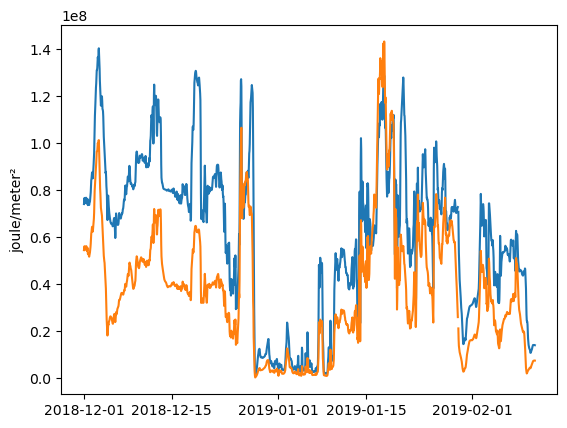

In [243]:
plt.plot(ds.time, IHC)
plt.plot(ds.time, IHT.magnitude)

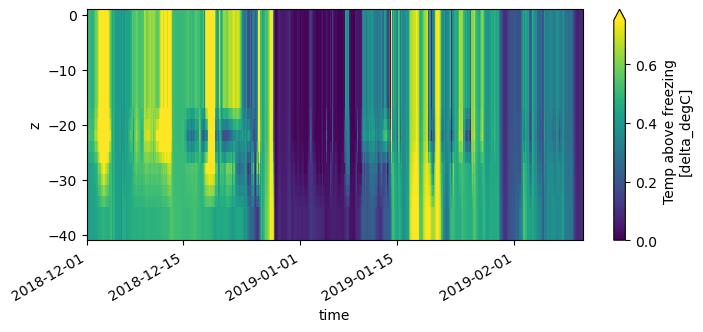

In [232]:
fig, ax= plt.subplots(figsize=(8,3))
ds.dT.plot(vmin=0, vmax=0.75)

In [233]:

# time_range = slice(datetime(2024,1,2), datetime(2024,1,17))

time_range = slice(datetime(2019,1,15), datetime(2019,1,21))

# time_range = slice(datetime(2018,1,1), datetime(2018,1,21))

# time_range = slice(datetime(2017,12,21), datetime(2018,1,2))


# time_range = slice(datetime(2016,12,5), datetime(2016,12,10))


# time_range = slice(datetime(2019,12,7), datetime(2019,12,20))

DS = xr.open_dataset(f'../data/polynya_size/daily_polynya_{time_range.stop.year}_sic10_v6.nc')
DS = DS.sel(time = time_range)

DS['length'] = DS['l_max'] - DS['l_min']

DS['t'] = ((DS.time.values - DS.time.values[0]) / np.timedelta64(1, 's')) * units('s').to('hour')

In [234]:
dsp = xr.open_dataset(f'../data/forcing/regional_hourly_era_{time_range.stop.year}_v0.nc')
dsp = dsp.sel(time = time_range)

Va = vectors.comp_along_theta(dsp.u10.values, dsp.v10.values, 160*units('degree')) * units('m/s')
Vap = vectors.comp_along_theta(dsp.u10.values, dsp.v10.values, (160-90)*units('degree')) * units('m/s')

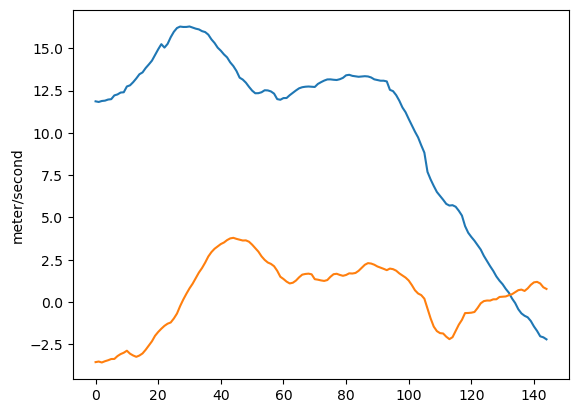

In [235]:
plt.plot(Va)
plt.plot(Vap)

In [236]:
# polynya length



# Va = 20 * units('m/s')

# Vi = 30 * units('cm/s') # rate of pack ice advection from shore
Vi = 0.035 * Va

Fi = 1 * units('cm/hour') # ice production rate

Hi = 1 * units('m') # frazil ice collection depth

# t = np.arange(0, 360) * units('hour')

t = np.arange(0, len(Vi)) * units('hour')




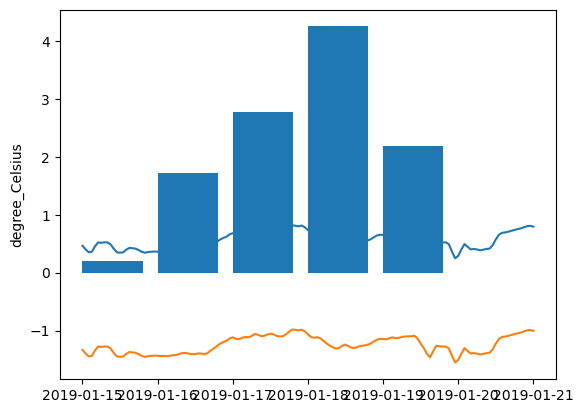

In [239]:
plt.plot(dsp.time, mean_dt.sel(time = time_range))
plt.bar(DS.time, DS.extent/1000, align='edge')
plt.plot(dsp.time, Tw)

In [123]:
HC_i - dQ

<Quantity(63335856.5, 'joule / meter ** 2')>

In [134]:
dQ

<Quantity(1800000.0, 'joule / meter ** 2')>

In [194]:
dT = (Twi - Tf).magnitude * units('delta_degC')
DQ = dT * (cst['Cp_o']*sigi) * 40 * units('m')

In [196]:
(DQ/Qi).to('hour')

<Quantity(36.3455648, 'hour')>

In [171]:
(cst['Cp_o'])

<Quantity(3850.0, 'joule / kilogram / delta_degree_Celsius')>

In [129]:
dQ/(cst['Cp_o'] * sigi)

<xarray.DataArray 'sig0' ()>
<Quantity(0.455679988, 'delta_degree_Celsius / meter ** 2')>

In [ ]:
def find_dQ(Tw, Ta, Ua):
    
    # define positive upward
    Qlu = find_Qlu(Twi, cst['sigma_sb'], 0.98)
    Qld = -find_Qld(Ta, cst['sigma_sb'], 0.95)
    Qs = -find_Qs(Ta, Twi, rho_a, cst['Cp_a'], Ua)
    # print(Qs)

    Qnet = Qlu + Qld + Qs
    
    return Qnet

In [351]:
# initial values
Twi = np.mean((mean_dt.sel(time = time_range).values+Tf.magnitude)[:12])*units('degC')
sigi = np.mean(mean_sig.sel(time=time_range)[:12]).values * units('kg/m3')
HC_i = np.nanmean(IHC_event[:12])


In [368]:
dt = (1*units('hour').to('s'))
dh = int(dt.to('hour').magnitude)
DZ = 40*units('m')

In [382]:
Hc = [HC_i]
Tw = [Twi]
Ua = [np.nanmean(Va[ii*dh:(ii+1)*dh])]
t = [0]

for ii in range(0,32):

    Qt = find_dQ(Tw[-1], Ta, Ua[-1])
    dQ = (Qt * dt).to('J/m2')

    # find cooling rate 
    dTdt = -dQ/((cst['Cp_o']*sigi) * DZ)

    # save new Hc
    Hc.append(Hc[-1] - dQ)
    # save new temp
    Tw.append((Tw[-1].magnitude + dTdt.magnitude) * units('degree_Celsius'))
    # next wind
    Ua.append(np.nanmean(Va[ii*dh:(ii+1)*dh]))
    
    t.append(t[-1] + dt.to('hour').magnitude)

In [383]:
uu = [U.magnitude for U in Ua]
hhcc = [H.magnitude for H in Hc]
tw = [T.magnitude for T in Tw]

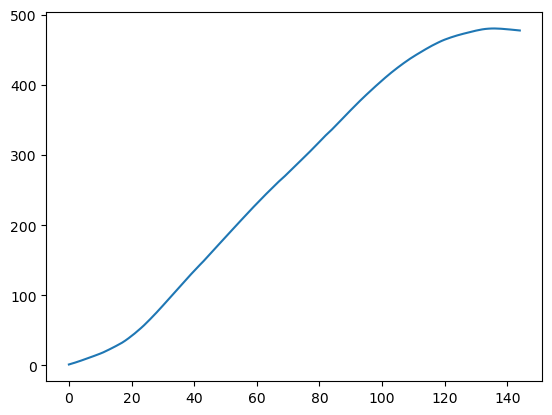

In [445]:
dtt = (((U.sel(time=time_range).time - U.sel(time=time_range).time[0]).values / np.timedelta64(1,'h')))
advection = (np.cumsum(U.sel(time=time_range).mean('z') * 1 * units('hour').to('s'))/1000) * units('km')
plt.plot(dtt, advection)

<>:5: SyntaxWarning: invalid escape sequence '\c'
<>:5: SyntaxWarning: invalid escape sequence '\c'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_8955/2843548301.py:5: SyntaxWarning: invalid escape sequence '\c'
  ax.set_ylabel('Water parcel T ($^{\circ}$C)', c='b')


Text(0, 0.5, 'Parcel transport (km)\nalong shelf current')

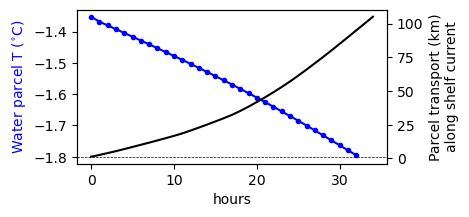

In [456]:
fig, ax = plt.subplots(figsize=(4,2))
# plt.plot(uu)
# plt.plot(t,hhcc)
plt.plot(t, tw, marker='.', c='b')
ax.set_ylabel('Water parcel T ($^{\circ}$C)', c='b')
plt.axhline(Tf, lw=0.5, ls='dashed', c='k')
plt.xlabel('hours')

ax2 = ax.twinx()
ax2.plot(dtt[:35], advection[:35], c='k')
ax2.set_ylabel('Par0cel transport (km)\nalong shelf current')



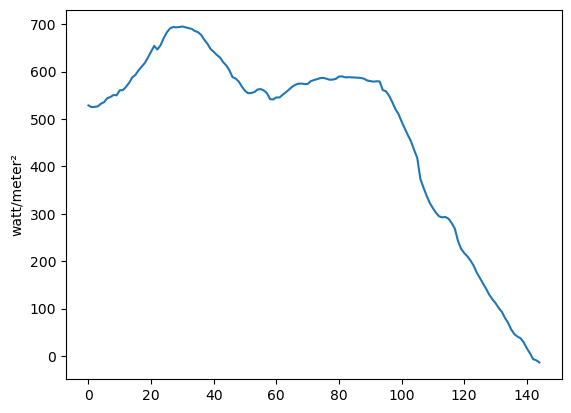

In [93]:
# plt.plot(Qlu+Qld)
# plt.plot(Qs)
plt.plot(Qnet)

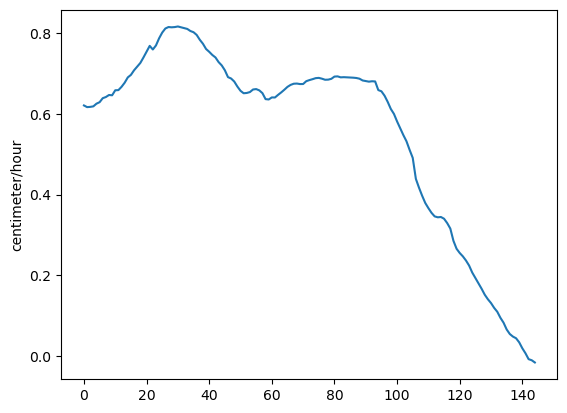

In [80]:

# for now, ignore evaporative latent heat flux, and shortwave radiation for winter

Ta = -17 * units('degC')
rho_a = cst['rho_a']

Tf = -1.8 *units('delta_degC')
Tw = -1.8 * units('degC')



# define positive upward
Qlu = find_Qlu(Tw, cst['sigma_sb'], 0.98)
Qld = -find_Qld(Ta, cst['sigma_sb'], 0.95)
Qs = -find_Qs(Ta, Tw, rho_a, cst['Cp_a'], Va)
# print(Qs)

Qnet = Qlu + Qld + Qs

dHdt = (Qnet / (cst['L_i'] * cst['rho_i'])).to('cm/hour')

plt.plot(dHdt)

<BarContainer object of 193 artists>

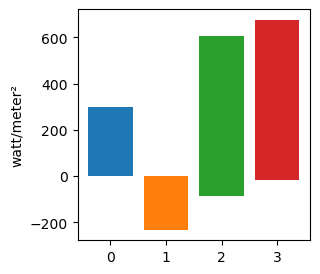

In [48]:
fig, ax = plt.subplots(figsize=(3,3))
plt.bar(0, Qlu)
plt.bar(1, Qld)
plt.bar(2, Qs)
plt.bar(3, Qnet)

In [414]:
# Q = m * C * dT


# dt = 12 *  units('hour')
# rho_o = cst['rho_o']
# H = 16 * units('m')
# dT = (Qnet * dt / (rho_o * H * cst['Cp_o'])).to_base_units()

rho_o = cst['rho_o']
H = 16 * units('m')
dT = (Tw.magnitude * units('delta_degC') - Tf)

(dT * rho_o * H * cst['Cp_o'] / Qnet).to('hour')

# change 

Magnitude,[0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0 -0.0 -0.0 -0.0]
Units,hour


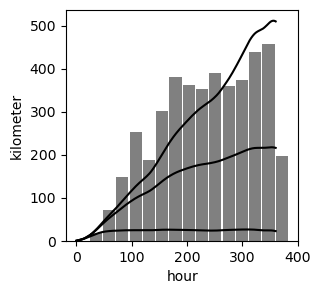

In [415]:
fig, ax= plt.subplots(figsize=(3,3))

plt.bar(DS.t.values, DS.length.values, width=22, align='edge', color='gray')


# X_ip  = xp_over_time_iter(Vi, t, dHdt, Hi = 1 * units('m'))
# X_zip = xp_over_time_iter(Vi, t, np.full(len(dHdt), 0)*units('m/hour'), Hi = 1 * units('m'))

# T = 360 # hours

# Vi = np.full(T, 20*0.03) * units('m/s')
# t = np.arange(T) * units('hour')
# Fi = np.full(T, dHdt) * dHdt.units

Fi = dHdt

X_ip  = xp_over_time_iter(Vi, t, Fi, Hi = 0.1 * units('m'))
X_hip = xp_over_time_iter(Vi, t, 0.1*Fi, Hi = 0.1 * units('m'))
X_zip = xp_over_time_iter(Vi, t, np.full(len(Fi), 0)*units('m/hour'), Hi = 0.1 * units('m'))



# Fi = 0.0001 * units('cm/hour') # ice production rate
plt.plot(t, X_ip, c='k')
plt.plot(t, X_hip, c='k')
plt.plot(t, X_zip, c='k')


In [416]:
np.max(X_ip)

<Quantity(26.1498856, 'kilometer')>

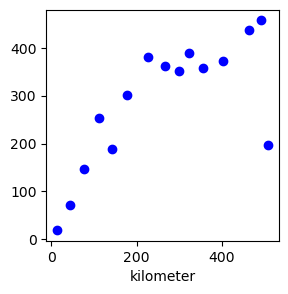

In [407]:
fig,ax=plt.subplots(figsize=(3,3))
# plt.scatter(X_ip[::24], DS.length.values, c='k')
plt.scatter(X_zip[::24], DS.length.values, c='b')


In [380]:
DS

<xarray.Dataset>
Dimensions:               (time: 14, t: 14)
Coordinates:
  * time                  (time) datetime64[ns] 2019-12-07 ... 2019-12-20
  * t                     (t) float64 0.0 24.0 48.0 72.0 ... 264.0 288.0 312.0
Data variables: (12/25)
    N                     (time) float64 ...
    extent                (time) float64 ...
    l_min                 (time) float64 ...
    l_max                 (time) float64 ...
    l_mean                (time) float64 ...
    l_per5                (time) float64 ...
    ...                    ...
    ice_extent            (time) float64 ...
    ocean_extent          (time) float64 ...
    other_polynya_extent  (time) float64 ...
    polynya_extent        (time) float64 ...
    miss_flag             (time) bool ...
    length                (time) float64 nan 20.73 60.69 ... 390.0 62.35 nan

In [267]:
np.nanmax(X_ip)

<Quantity(11.9967615, 'kilometer')>